# Topic modeling on PWDB textual data

## Importing libraries

In [64]:
import spacy
from spacy.tokens import Token
from spacy.tokens.doc import Doc
from spacy.tokens.span import Span

nlp = spacy.load("en_core_web_sm")

import gensim
from gensim.models import TfidfModel, LdaModel, CoherenceModel, Phrases
from gensim.utils import simple_preprocess
import re

from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.topic_visualizer import generate_wordcloud
from sem_covid.services.data_registry import Dataset
from sem_covid.services.sc_wrangling.data_cleaning import clean_text_from_specific_characters, clean_remove_stopwords
import pyLDAvis.gensim_models
from typing import List, Union

/home/lps/work/workspace-charm/sem-covid/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Fetching data from document store

In [2]:
pwdb = Dataset.PWDB.fetch()

document_corpus = pwdb['title'].map(str) + '. ' + \
                  pwdb['background_info_description'].map(str) + '. ' + \
                  pwdb['content_of_measure_description'].map(str) + '. ' + \
                  pwdb['use_of_measure_description'] + '. ' + \
                  pwdb['involvement_of_social_partners_description']

/home/lps/work/workspace-charm/sem-covid/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100% (1288 of 1288) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


## Data preprocessing
- data cleanup
- turn corpus into spacy Docs

In [3]:
unused_characters = ["\\r", ">", "\n", "\\", "<", "''", "%", "...", "\'", '"', "(", "\n", "*", "1)", "2)", "3)",
                     "[", "]"]
document_corpus = document_corpus.apply(clean_text_from_specific_characters, characters=unused_characters)
spacy_corpus = document_corpus.apply(nlp)


/home/lps/work/workspace-charm/sem-covid/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Defining filtering functions
 Helper functions for filtering spacy documents

In [90]:
spacy_stop_words = nlp.Defaults.stop_words

def filter_stop_words(doc: List[Token], stop_words: List[str] = nlp.Defaults.stop_words) -> List[Token]:
    """
        turn a spacy Doc into a list of token and remove stop words
    """
    return [token for token in doc if str(token) not in stop_words]

def filter_pos(doc:Doc, pos: Union[str,List[str]]) -> List[Token]:
    """
        filter out tokens that have the provided POS
    """
    poses = []
    if isinstance(pos,str):
        poses = [pos]
    else:
        poses = pos
    return [token for token in doc if token.pos_ not in poses]

def select_pos(doc:Doc, pos: Union[str,List[str]]) -> List[str]:
    """
        select tokens that have the desired POS
    """
    poses = []
    if isinstance(pos,str):
        poses = [pos]
    else:
        poses = pos
    return [token for token in doc if token.pos_ in poses]

def filter_stop_words_on_a_span_list(span_list: List[Span],
                                     stop_words: List[str] = nlp.Defaults.stop_words) -> str:
    """
        Spacy noun phrases are provided as a list of Spans.
        Some noun phrases contain stop words, and we want those removed.
    """
    return list(filter(None, ["_".join(map(str, filter_stop_words(span, stop_words))) for span in span_list]))


/home/lps/work/workspace-charm/sem-covid/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Preparing few corpora

Filter document tokens. Select only the needed/interesting tokens for Topic modeling:
   - all words,
   - nouns
   - verbs
   - noun phrases

/home/lps/work/workspace-charm/sem-covid/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



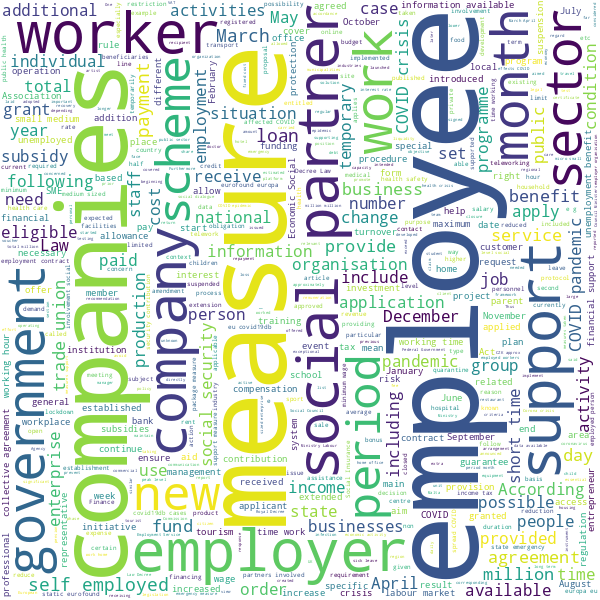

In [127]:
word_corpus = spacy_corpus.apply(filter_stop_words, stop_words=spacy_stop_words)
word_corpus = word_corpus.apply(filter_pos, pos="PUNCT")
word_corpus = word_corpus.apply(lambda x: list(map(str,x)))

generate_wordcloud( " ".join( [" ".join(doc) for doc in word_corpus]) )

/home/lps/work/workspace-charm/sem-covid/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



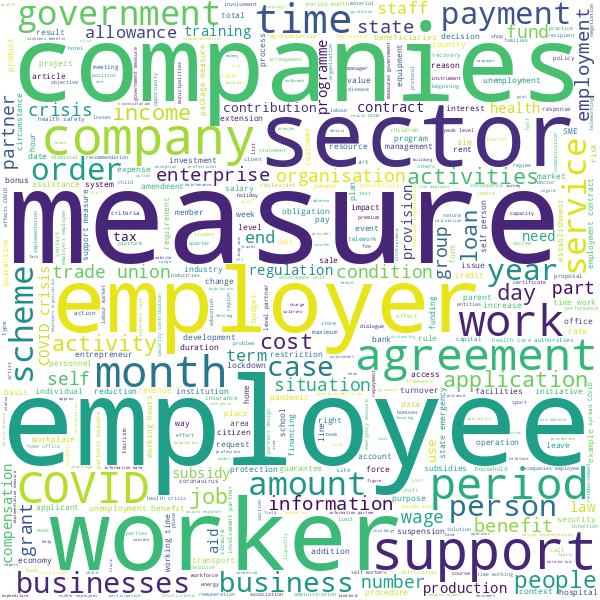

In [128]:
noun_corpus = spacy_corpus.apply(select_pos, pos="NOUN")
noun_corpus = noun_corpus.apply(lambda x: list(map(str,x)))

generate_wordcloud( " ".join( [" ".join(doc) for doc in noun_corpus]) )

/home/lps/work/workspace-charm/sem-covid/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



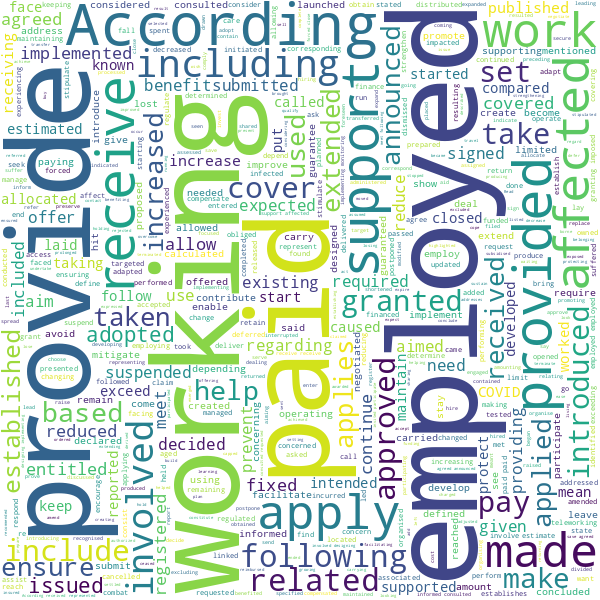

In [129]:
verb_corpus = spacy_corpus.apply(select_pos, pos="VERB")
verb_corpus = verb_corpus.apply(lambda x: list(map(str,x)))

generate_wordcloud( " ".join( [" ".join(doc) for doc in verb_corpus]) )

/home/lps/work/workspace-charm/sem-covid/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



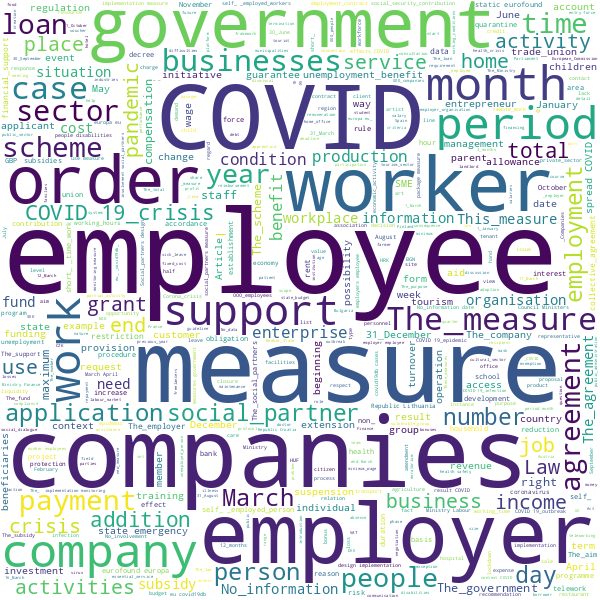

In [130]:
noun_phrase_corpus = spacy_corpus.apply(lambda x: x.noun_chunks)
noun_phrase_corpus = noun_phrase_corpus.apply(filter_stop_words_on_a_span_list)

generate_wordcloud( " ".join( [" ".join(doc) for doc in noun_phrase_corpus]) )